# Contact Policy Optimization

This is a starter notebook. We'll fill it in Step 2.


In [1]:
from pathlib import Path
import pandas as pd, numpy as np

PROJ = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
PROC = PROJ / "data" / "processed"
PROC.mkdir(parents=True, exist_ok=True)

scores = pd.read_csv(PROC / "hillstrom_uplift_scores_test.csv")
scores = scores.sort_values("uplift_hat", ascending=False).reset_index(drop=True)

# cumulative incremental *revenue* from the randomized test (IPW)
cum_gain = scores["ipw_contrib"].cumsum().to_numpy()
n = np.arange(1, len(scores) + 1)

pd.DataFrame({"n": n, "cum_gain": cum_gain}).head()


,n,cum_gain
0,1,-0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [2]:
margin_rate = 0.30   # 30% gross margin on incremental spend
email_cost  = 0.05   # $0.05 per email sent

# Profit for contacting the top-n by uplift: margin * incremental_rev - cost * n
profit_curve = margin_rate * cum_gain - email_cost * n

best_idx = int(profit_curve.argmax()) + 1  # n is 1-based here
best_pct = round(100 * best_idx / len(scores), 2)

best = {
    "best_n": int(best_idx),
    "best_pct": best_pct,
    "expected_incremental_revenue": float(cum_gain[best_idx-1]),
    "expected_profit": float(profit_curve[best_idx-1]),
    "expected_cost": float(email_cost * best_idx),
    "expected_profit_per_contact": float(profit_curve[best_idx-1] / best_idx),
}

print("Best policy:",
      f"contact top {best['best_pct']}% (n={best['best_n']})",
      f"\n  Incremental revenue ≈ {best['expected_incremental_revenue']:.2f}",
      f"\n  Cost ≈ {best['expected_cost']:.2f}",
      f"\n  Profit ≈ {best['expected_profit']:.2f}",
      f"\n  Profit/contact ≈ {best['expected_profit_per_contact']:.4f}", sep="")


Best policy:contact top 99.09% (n=15855)
  Incremental revenue ≈ 10191.24
  Cost ≈ 792.75
  Profit ≈ 2264.62
  Profit/contact ≈ 0.1428


In [3]:
curve = pd.DataFrame({
    "n": n,
    "cum_gain_revenue": cum_gain,
    "profit": profit_curve,
    "profit_per_contact": profit_curve / n
})
curve.to_csv(PROC / "policy_curve_email.csv", index=False)

contact_list = scores.loc[:best_idx-1, ["row_id","uplift_hat"]].copy()
contact_list["rank"] = np.arange(1, best_idx+1)
contact_list.to_csv(PROC / "policy_contact_list.csv", index=False)

print("Saved:", PROC / "policy_curve_email.csv")
print("Saved:", PROC / "policy_contact_list.csv")
contact_list.head(10)


Saved: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\policy_curve_email.csv
Saved: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\policy_contact_list.csv


,row_id,uplift_hat,rank
0,11786,267.869600,1
1,13574,235.279467,2
2,8911,164.670000,3
3,9527,146.373333,4
4,10755,136.221167,5
5,10271,122.005300,6
6,3177,120.406233,7
7,7190,116.433333,8
8,9130,114.025333,9
9,11706,105.179967,10


In [4]:
import numpy as np, pandas as pd
from pathlib import Path

PROJ = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
PROC = PROJ / "data" / "processed"

curve = pd.read_csv(PROC / "policy_curve_email.csv")

# 1) Profit should peak where we reported:
best_idx = int(curve["profit"].idxmax())
curve.iloc[[best_idx]]

# 2) How many test rows have positive *marginal* profit at the end?
marginal_profit_per_contact = curve["profit"].diff().fillna(curve.loc[0, "profit"])
(marginal_profit_per_contact > 0).sum(), len(curve)

# 3) Profit at 10%, 25%, 50%, 75%, 100% coverage
for pct in [0.1, 0.25, 0.5, 0.75, 1.0]:
    n = int(len(curve) * pct)
    print(pct, round(curve.iloc[n-1]["profit"], 2))


0.1 421.45
0.25 857.5
0.5 1677.34
0.75 1428.61
1.0 2257.37


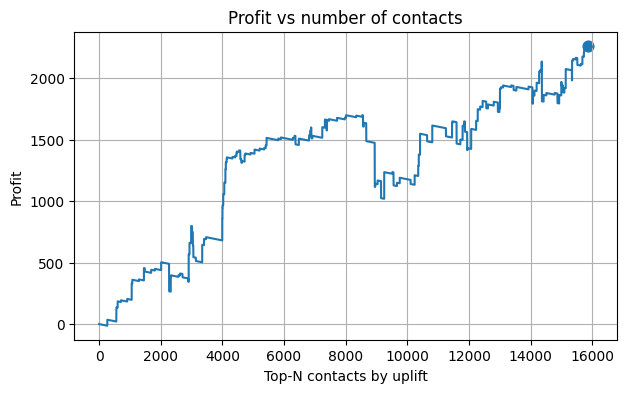

Share with positive marginal profit: 0.0074375


,n,marginal_profit
15990,15991,-0.05
15991,15992,-0.05
15992,15993,-0.05
15993,15994,-0.05
15994,15995,-0.05
15995,15996,-0.05
15996,15997,-0.05
15997,15998,-0.05
15998,15999,-0.05
15999,16000,-0.05


In [5]:
import matplotlib.pyplot as plt

PROJ = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
PROC = PROJ / "data" / "processed"
curve = pd.read_csv(PROC / "policy_curve_email.csv")

# Profit curve + best point
best_i = int(curve["profit"].idxmax())
fig = plt.figure(figsize=(7,4))
plt.plot(curve["n"], curve["profit"])
plt.scatter([curve.loc[best_i,"n"]],[curve.loc[best_i,"profit"]], s=60)
plt.title("Profit vs number of contacts")
plt.xlabel("Top-N contacts by uplift")
plt.ylabel("Profit")
plt.grid(True)
plt.show()

# Marginal profit per additional contact (should stay >=0 near the end if 100% is best)
curve["marginal_profit"] = curve["profit"].diff().fillna(curve["profit"].iloc[0])
print("Share with positive marginal profit:", (curve["marginal_profit"]>0).mean())
curve[["n","marginal_profit"]].tail(10)


In [6]:
from pathlib import Path
import json, pandas as pd, numpy as np

PROJ = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
PROC = PROJ / "data" / "processed"

# 1) Reload the curve we just created
curve = pd.read_csv(PROC / "policy_curve_email.csv")      # columns: n, profit, cum_gain
scores = pd.read_csv(PROC / "hillstrom_uplift_scores_test.csv")  # columns include: row_id, uplift_hat

# 2) Best point on the curve
best_idx = int(curve["profit"].idxmax())
best_row = curve.loc[best_idx]
best_n   = int(best_row["n"])
best_profit = float(best_row["profit"])

# 3) Recreate the contact list (top-N by uplift)
contact_list = (scores
   .sort_values("uplift_hat", ascending=False)
   .head(best_n)
   .assign(rank=lambda d: np.arange(1, len(d)+1))[["row_id","uplift_hat","rank"]]
)
contact_path = PROC / "policy_contact_list.csv"
contact_list.to_csv(contact_path, index=False)

# 4) Save a small JSON with policy economics (edit margin/cost here if you like)
policy = {
    "channel": "email",
    "margin_rate": 0.30,
    "unit_cost": 0.05,
    "best_n": best_n,
    "best_profit": round(best_profit, 2),
    "share_of_population": round(100*best_n/len(scores), 2),
    "artifacts": {
        "curve": str(PROC / "policy_curve_email.csv"),
        "contact_list": str(contact_path)
    }
}
with open(PROC / "policy_summary.json", "w") as f:
    json.dump(policy, f, indent=2)

print("Saved:", contact_path)
print("Saved:", PROC / "policy_summary.json")
display(contact_list.head(10))
policy


Saved: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\policy_contact_list.csv
Saved: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\policy_summary.json


,row_id,uplift_hat,rank
0,11786,267.869600,1
1,13574,235.279467,2
2,8911,164.670000,3
3,9527,146.373333,4
4,10755,136.221167,5
5,10271,122.005300,6
6,3177,120.406233,7
7,7190,116.433333,8
8,9130,114.025333,9
9,11706,105.179967,10


{'channel': 'email',
 'margin_rate': 0.3,
 'unit_cost': 0.05,
 'best_n': 15855,
 'best_profit': 2264.62,
 'share_of_population': 99.09,
 'artifacts': {'curve': 'C:\\Users\\balla\\Downloads\\clv-uplift-optimizer-starter\\clv-uplift-optimizer\\data\\processed\\policy_curve_email.csv',
  'contact_list': 'C:\\Users\\balla\\Downloads\\clv-uplift-optimizer-starter\\clv-uplift-optimizer\\data\\processed\\policy_contact_list.csv'}}

In [7]:
def best_profit_for(margin_rate, unit_cost):
    # recompute profit from saved cum_gain
    curve = pd.read_csv(PROC / "policy_curve_email.csv")
    # if curve lacks cum_gain, merge from hillstrom_uplift_curve.csv
    if "cum_gain" not in curve:
        gain = pd.read_csv(PROC / "hillstrom_uplift_curve.csv")[["n","cum_gain"]]
        curve = curve.merge(gain, on="n", how="left")
    curve["profit_alt"] = margin_rate*curve["cum_gain"] - unit_cost*curve["n"]
    row = curve.loc[curve["profit_alt"].idxmax()]
    return margin_rate, unit_cost, int(row["n"]), float(row["profit_alt"])

for m in (0.2, 0.3, 0.4):
    for c in (0.03, 0.05, 0.07):
        print(best_profit_for(m, c))


(0.2, 0.03, 15855, 1562.5970386561198)
(0.2, 0.05, 15855, 1245.4970386561197)
(0.2, 0.07, 15855, 928.3970386561195)
(0.3, 0.03, 15855, 2581.7205579841793)
(0.3, 0.05, 15855, 2264.6205579841794)
(0.3, 0.07, 15855, 1947.5205579841793)
(0.4, 0.03, 15855, 3600.8440773122393)
(0.4, 0.05, 15855, 3283.7440773122394)
(0.4, 0.07, 15855, 2966.6440773122395)


In [9]:
import pandas as pd, json, pathlib as p
PROC = (p.Path.cwd().parents[0] if p.Path.cwd().name=="notebooks" else p.Path.cwd())/"data/processed"
curve  = pd.read_csv(PROC/"policy_curve_email.csv")
scores = pd.read_csv(PROC/"hillstrom_uplift_scores_test.csv")
contact= pd.read_csv(PROC/"policy_contact_list.csv")
summary= json.loads((PROC/"policy_summary.json").read_text())

assert contact.shape[0]==summary["best_n"]
assert int(curve.loc[curve["profit"].idxmax(),"n"])==summary["best_n"]
print("All good ✔︎ | best_n:", summary["best_n"], "| best_profit:", summary["best_profit"])

All good ✔︎ | best_n: 15855 | best_profit: 2264.62
